2. Causal Inference: Estimating the Conditional Average Treatment Effect (CATE)
Objective:
To assess how different meta-learners (T-Learner, S-Learner, X-Learner, R-Learner) estimate the Conditional Average Treatment Effect (CATE) in this educational setting, where the treatment is binary (growth mindset intervention).

Action Steps:
Model Setup:

Implement the different meta-learners (e.g., T-Learner, S-Learner, X-Learner, R-Learner).
Use student achievement (Y) as the outcome and treatment (Z) as the binary intervention variable.
Feature Selection:

Based on your correlation matrix, select relevant features that might moderate the effect of the treatment. Key variables include:
Fixed Mindset (X1): Schools with different mindset levels might respond differently to the intervention.
School Achievement Level (X2): Higher or lower-achieving schools might show varied responses.
Minority Composition (X3) and Poverty Concentration (X4): Demographic factors that could moderate the intervention effect.
Model Evaluation:

Compare the performance of each meta-learner in terms of estimating the treatment effect. Metrics to evaluate include:
Mean Squared Error (MSE)
Bias-Variance Tradeoff
Interpretability of results.
Cross-validation:

Perform cross-validation to ensure the robustness of your CATE estimates across different subsets of the data

In [1]:
# Load and prepare data 
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = pd.read_csv('../data/dataset.csv')
print(dataset.head())

# Features and target
X = dataset[['X1', 'X2', 'X3', 'X4', 'X5']]  # Covariates that moderate the treatment effect
y = dataset['Y']  # Outcome: Student Achievement
treatment = dataset['Z']  # Binary treatment: Growth mindset intervention

# Split data into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.3, random_state=42)

   schoolid  Z         Y  S3  C1  C2  C3  XC        X1        X2        X3  \
0        76  1  0.081602   6   4   2   1   4  0.334544  0.648586 -1.310927   
1        76  1 -0.385869   4  12   2   1   4  0.334544  0.648586 -1.310927   
2        76  1  0.398184   6   4   2   0   4  0.334544  0.648586 -1.310927   
3        76  1 -0.175037   6   4   2   0   4  0.334544  0.648586 -1.310927   
4        76  1  0.884583   6   4   1   0   4  0.334544  0.648586 -1.310927   

         X4        X5  
0  0.224077 -0.426757  
1  0.224077 -0.426757  
2  0.224077 -0.426757  
3  0.224077 -0.426757  
4  0.224077 -0.426757  


In [4]:
# T-Learner
from sklearn.ensemble import RandomForestRegressor
from econml.metalearners import TLearner

# Initialize models for the treatment and control groups
t_learner = TLearner(models=RandomForestRegressor())

# Fit the T-Learner
t_learner.fit(y_train, treatment_train, X=X_train)

# Estimate the treatment effect on the test set
cate_t_learner = t_learner.effect(X_test)

In [5]:
# S-Learner
from econml.metalearners import SLearner

# Initialize the model
s_learner = SLearner(overall_model=RandomForestRegressor())

# Fit the S-Learner
s_learner.fit(y_train, treatment_train, X=X_train)

# Estimate the treatment effect
cate_s_learner = s_learner.effect(X_test)


In [6]:
# X-Learner
from econml.metalearners import XLearner

# Initialize the model
x_learner = XLearner(models=RandomForestRegressor())

# Fit the X-Learner
x_learner.fit(y_train, treatment_train, X=X_train)

# Estimate the treatment effect
cate_x_learner = x_learner.effect(X_test)


In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Step 1: Fit the treatment model (propensity score model)
# Model to predict treatment assignment based on covariates (propensity score)
model_t = RandomForestRegressor()  # You can change this to another model
model_t.fit(X_train, treatment_train)

# Predict the treatment (propensity score)
treatment_pred_train = model_t.predict(X_train)
treatment_pred_test = model_t.predict(X_test)

# Step 2: Fit the outcome model (y given X)
# Model to predict the outcome (student achievement)
model_y = RandomForestRegressor()  # You can change this to another model
model_y.fit(X_train, y_train)

# Predict the outcome
outcome_pred_train = model_y.predict(X_train)
outcome_pred_test = model_y.predict(X_test)

# Step 3: Calculate residuals (R-Learner stage)
# Residuals for the outcome
y_residual_train = y_train - outcome_pred_train
y_residual_test = y_test - outcome_pred_test

# Residuals for the treatment (centering the treatment variable)
t_residual_train = treatment_train - treatment_pred_train
t_residual_test = treatment_test - treatment_pred_test

# Convert residuals to NumPy arrays to use reshape
t_residual_train = t_residual_train.to_numpy().reshape(-1, 1)
t_residual_test = t_residual_test.to_numpy().reshape(-1, 1)

# Step 4: Fit the final model to estimate treatment effect using residuals
# You can use any regression model for this step. LinearRegression is a simple choice.
final_model = LinearRegression()
final_model.fit(t_residual_train, y_residual_train)

# Step 5: Estimate treatment effects on the test set
cate_r_learner = final_model.predict(t_residual_test)



Estimated CATE on the test set:
[-0.08566627  0.21880721  0.18976879 ... -0.09828028 -0.08604337
  0.21560635]


In [23]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for each meta-learner's estimated CATE
mse_t_learner = mean_squared_error(y_test, cate_t_learner)
mse_s_learner = mean_squared_error(y_test, cate_s_learner)
mse_x_learner = mean_squared_error(y_test, cate_x_learner)
mse_r_learner = mean_squared_error(y_test, cate_r_learner)

# Print results
print("MSE - T-Learner:", mse_t_learner)
print("MSE - S-Learner:", mse_s_learner)
print("MSE - X-Learner:", mse_x_learner)
print("MSE - R-Learner:", mse_r_learner)


MSE - T-Learner: 0.5724839918507568
MSE - S-Learner: 0.5746039330117034
MSE - X-Learner: 0.572388666611906
MSE - R-Learner: 0.41128733554894353


In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from econml.metalearners import TLearner, SLearner, XLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models for the meta-learners
t_learner = TLearner(models=RandomForestRegressor())
s_learner = SLearner(overall_model=RandomForestRegressor())
x_learner = XLearner(models=RandomForestRegressor())

# Prepare lists to store MSE for each learner
mse_t_learner_scores = []
mse_s_learner_scores = []
mse_x_learner_scores = []
mse_r_learner_scores = []

# For R-Learner, we use a manual implementation
model_t = RandomForestRegressor()  # Treatment model for R-Learner
model_y = RandomForestRegressor()  # Outcome model for R-Learner
final_model = LinearRegression()   # Final model for R-Learner residual regression

# Perform K-Fold cross-validation for each learner
for train_index, test_index in kf.split(X):
    # Train/test split for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]

    # T-Learner
    t_learner.fit(y_train, treatment_train, X=X_train)
    cate_t_learner = t_learner.effect(X_test)
    mse_t_learner_scores.append(mean_squared_error(y_test, cate_t_learner))

    # S-Learner
    s_learner.fit(y_train, treatment_train, X=X_train)
    cate_s_learner = s_learner.effect(X_test)
    mse_s_learner_scores.append(mean_squared_error(y_test, cate_s_learner))

    # X-Learner
    x_learner.fit(y_train, treatment_train, X=X_train)
    cate_x_learner = x_learner.effect(X_test)
    mse_x_learner_scores.append(mean_squared_error(y_test, cate_x_learner))

    # R-Learner (manual implementation)
    # Step 1: Fit treatment model
    model_t.fit(X_train, treatment_train)
    treatment_pred_train = model_t.predict(X_train)
    
    # Step 2: Fit outcome model
    model_y.fit(X_train, y_train)
    outcome_pred_train = model_y.predict(X_train)
    
    # Step 3: Calculate residuals
    t_residual_train = treatment_train - treatment_pred_train
    y_residual_train = y_train - outcome_pred_train
    
    # Step 4: Fit final model using residuals
    final_model.fit(t_residual_train.values.reshape(-1, 1), y_residual_train)
    
    # Step 5: Predict CATE on the test set
    treatment_pred_test = model_t.predict(X_test)
    outcome_pred_test = model_y.predict(X_test)
    t_residual_test = treatment_test - treatment_pred_test
    y_residual_test = y_test - outcome_pred_test
    
    # Estimate treatment effects
    cate_r_learner = final_model.predict(t_residual_test.values.reshape(-1, 1))
    
    # Calculate MSE for this fold
    mse_r_learner_scores.append(mean_squared_error(y_test, cate_r_learner))

# Print the average MSE across folds for each learner
print("Average MSE - T-Learner:", np.mean(mse_t_learner_scores))
print("Average MSE - S-Learner:", np.mean(mse_s_learner_scores))
print("Average MSE - X-Learner:", np.mean(mse_x_learner_scores))
print("Average MSE - R-Learner:", np.mean(mse_r_learner_scores))


Average MSE - T-Learner: 0.5721765537974257
Average MSE - S-Learner: 0.5719210666983627
Average MSE - X-Learner: 0.5727028558330065
Average MSE - R-Learner: 0.40397486863641624


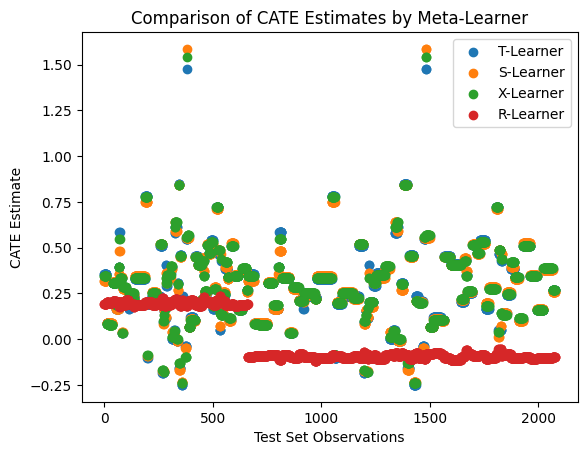

In [27]:
import matplotlib.pyplot as plt

# Plot CATE estimates for T-Learner
plt.scatter(range(len(cate_t_learner)), cate_t_learner, label='T-Learner')
plt.scatter(range(len(cate_s_learner)), cate_s_learner, label='S-Learner')
plt.scatter(range(len(cate_x_learner)), cate_x_learner, label='X-Learner')
plt.scatter(range(len(cate_r_learner)), cate_r_learner, label='R-Learner')
plt.legend()
plt.title('Comparison of CATE Estimates by Meta-Learner')
plt.xlabel('Test Set Observations')
plt.ylabel('CATE Estimate')
plt.show()
